# Understand your LLM with Mechanistic Interpretability and Visualizations

After developing a language model like MiniGPT, a rigorous and systematic evaluation becomes essential to understand its capabilities/limitations, and identify opportunities for refinement. Below, I outline the essential methods for rigorously assessing the model’s performance:

> **Perplexity -**This metric gauges how well the model predicts the next word in a sequence. A lower perplexity score signals stronger language modeling — it can be thought as the model’s confidence level in its predictions.

> **Loss Tracking –** By keeping an eye on training loss, we can track how effectively the model learns over epochs.

> **Attention Analysis –** To gain a deeper understanding of the model’s decision-making process, visualization techniques such as heatmaps or network graphs can be employed to examine attention weights. This method elucidates how MiniGPT allocates focus across input sequences, enhancing the interpretability of its behavior.

> **Embedding Visualization –** Mapping learned embeddings (e.g., using t-SNE or PCA) helps interpret how the model clusters words and captures semantic relationships.

> **Human Evaluation -** To assess qualitative performance, human evaluators score the model’s responses to carefully selected prompts based on criteria such as fluency, coherence, and relevance.

Together, these methods don’t just measure performance—they unlock insights into how MiniGPT interprets language, paving the way for smarter, more transparent AI.

In [2]:
# Import relevant libraries

! pip install -q lightning

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import lightning as L
# Ignore all warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Position encoding

In [3]:
class PositionEncoding(nn.Module):
    def __init__(self, d_model=2, max_len=6):
        super().__init__()
        pe = torch.zeros(max_len, d_model)

        # Precompute positional encodings
        position = torch.arange(max_len, dtype=torch.float).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-torch.log(torch.tensor(10000.0)) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add batch dimension for broadcasting: [1, max_len, d_model]
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, word_embeddings):
        """
        Add positional encodings to batched word embeddings.
        Args:
            word_embeddings: [batch_size, seq_len, d_model]
        Returns:
            [batch_size, seq_len, d_model]
        """
        seq_len = word_embeddings.size(1)  # Get sequence length from dim 1
        # Slice pe to match seq_len: [1, seq_len, d_model]
        pe_slice = self.pe[:, :seq_len, :]
        # Broadcasting adds pe to each sequence in the batch
        return word_embeddings + pe_slice

## Multihead Attention Block

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=2, num_heads=2):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head

        # Linear projections for queries, keys, values, and output
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)

        # Add attribute to store attention weights
        self.attention_percents = None

    def forward(self, encodings_for_q, encodings_for_k, encodings_for_v, mask=None):
        batch_size, seq_len, _ = encodings_for_q.shape  # Shape: [batch_size, seq_len, d_model]

        # Linear projections
        q = self.W_q(encodings_for_q)  # [batch_size, seq_len, d_model]
        k = self.W_k(encodings_for_k)  # [batch_size, seq_len, d_model]
        v = self.W_v(encodings_for_v)  # [batch_size, seq_len, d_model]

        # Split into heads: [batch_size, num_heads, seq_len, d_k]
        q = q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # Compute attention scores: [batch_size, num_heads, seq_len, seq_len]
        sims = torch.matmul(q, k.transpose(-2, -1)) / (self.d_k ** 0.5)

        # Apply mask if provided
        if mask is not None:
            mask = mask.unsqueeze(1)  # [batch_size, 1, seq_len, seq_len] for broadcasting
            sims = sims.masked_fill(mask, -1e9)

        # Softmax to get attention weights
        attention_percents = F.softmax(sims, dim=-1)
        # Store the attention weights
        self.attention_percents = attention_percents

        # Compute attention output: [batch_size, num_heads, seq_len, d_k]
        attention_output = torch.matmul(attention_percents, v)

        # Concatenate heads: [batch_size, seq_len, d_model]
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)

        # Final linear projection: [batch_size, seq_len, d_model]
        output = self.W_o(attention_output)
        return output

## Decoder layer

In [5]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model=2, num_heads=2, d_ff=8, dropout=0.1):
        super().__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        # Self-attention sub-layer
        attn_output = self.self_attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))  # Residual + norm

        # Feed-forward sub-layer
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))  # Residual + norm
        return x

## Decoder Only Transformer - Main class

In [6]:
class DecoderOnlyTransformer(L.LightningModule):
    def __init__(self, num_tokens=4, d_model=2, num_heads=2, num_layers=6, d_ff=8, max_len=6, dropout=0.1):
        super().__init__()
        L.seed_everything(seed=42)
        self.num_tokens = num_tokens
        self.d_model = d_model

        # Embedding and positional encoding
        self.we = nn.Embedding(num_embeddings=num_tokens, embedding_dim=d_model)
        self.pe = PositionEncoding(d_model=d_model, max_len=max_len)
        self.dropout = nn.Dropout(dropout)

        # Stack 6 decoder layers
        self.layers = nn.ModuleList([
            DecoderLayer(d_model=d_model, num_heads=num_heads, d_ff=d_ff, dropout=dropout)
            for _ in range(num_layers)
        ])

        # Output layer
        self.fc_layer = nn.Linear(d_model, num_tokens)
        self.loss = nn.CrossEntropyLoss(ignore_index=0)

    def forward(self, token_ids, attention_mask=None):
        batch_size, seq_len = token_ids.shape

        # Embeddings and positional encoding
        word_embeddings = self.we(token_ids)  # [batch_size, seq_len, d_model]
        x = self.pe(word_embeddings)
        x = self.dropout(x)

        # Create masks
        causal_mask = torch.tril(torch.ones(seq_len, seq_len)).to(token_ids.device) == 0
        causal_mask = causal_mask.unsqueeze(0).expand(batch_size, -1, -1)
        if attention_mask is None:
            padding_mask = (token_ids == 0).unsqueeze(1).expand(-1, seq_len, -1)
        else:
            padding_mask = (attention_mask == 0).unsqueeze(1).expand(-1, seq_len, -1)
        final_mask = causal_mask | padding_mask

        # Pass through 6 stacked layers
        for layer in self.layers:
            x = layer(x, mask=final_mask)  # [batch_size, seq_len, d_model]

        # Final output
        fc_layer_output = self.fc_layer(x)  # [batch_size, seq_len, num_tokens]
        return fc_layer_output

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.00025)

    def training_step(self, batch, batch_idx):
        input_tokens, labels = batch
        output = self.forward(input_tokens)
        loss = self.loss(output.view(-1, self.num_tokens), labels.view(-1))
        self.log("train_loss", loss, prog_bar=True)
        return loss

## Get training data

In [7]:
! pip install -q datasets
! pip install -q contractions

from datasets import load_dataset
import nltk
import regex as re
from contractions import contractions_dict
import torch
import numpy as np
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 7.1 MB/s eta 0:00:00


In [8]:
# Install required libraries
from datasets import load_dataset
import os

def clean_text(text):
    # Optional: Remove special characters (keep if meaningful)
    text = re.sub(r'[^a-zA-Z\s.,!?]', '', text)
    # Optional: Lowercase (skip if preserving case like GPT-1)
    text = text.lower()
    # Remove extra whitespace and normalize
    text = re.sub(r'\s+', ' ', text.strip())

    return text

# !pip install -q datasets

def get_roc_stories(num_stories):
    file_path = "ROC_data_train.txt"

    with open(file_path, 'r', encoding='utf-8') as file:
        # Read the entire file and split by double newline
        raw_stories = file.read().strip().split('\n')
    stories_list = []
    for each in raw_stories:
        clened_text = clean_text(each)
        stories_list.append(clened_text)
    if num_stories == "All":
        return stories_list
    return stories_list[:num_stories]

In [9]:
# Get token_to_id and id_to_token
# Tokenize all stories and count unique tokens
def get_dicts_from_stories(stories):
  from collections import Counter
  all_tokens = []
  for story in stories:
      tokens = tokenizer.tokenize(story)
      all_tokens.extend(tokens)

  # Build a reduced vocabulary
  token_counts = Counter(all_tokens)
  seen_vocab = {token: idx+1 for idx, (token, _) in enumerate(token_counts.items())}
  seen_vocab["<pad>"] = 0  # Add padding token
  token_to_id = seen_vocab
  id_to_token = {idx: token for token, idx in token_to_id.items()}
  return token_to_id, id_to_token

In [10]:
def prepare_inputs_labels_from_stories(stories,t_to_i,max_len_local):
  inputs_list = []
  labels_list = []

  for story in stories:
      tokens_global = tokenizer.tokenize(story)
                        #  , truncation=True, max_length=max_len_local, return_tensors="pt")["input_ids"].squeeze(0)
      tokens = [t_to_i.get(token, t_to_i["<pad>"]) for token in tokens_global]
      if len(tokens) < 2:  # Skip if too short
          continue
      # Input: all but last token, Label: all but first token
      input_ids = torch.tensor(tokens[:-1][:max_len_local])
      label_ids = torch.tensor(tokens[1:][:max_len_local])
      # Pad to max_len
      padding_length = max_len_local - len(input_ids)
      if padding_length > 0:
          input_ids = torch.cat([input_ids, torch.full((padding_length,), 0)]) #pad_token_id = 0
          label_ids = torch.cat([label_ids, torch.full((padding_length,), 0)]) #pad_token_id = 0
      inputs_list.append(input_ids)
      labels_list.append(label_ids)
  inputs_list_tensor = torch.stack(inputs_list)
  labels_list_tensor = torch.stack(labels_list)
  return inputs_list_tensor, labels_list_tensor

In [11]:
# BPE tokenizer from transformers import T5Tokenizer
from transformers import GPT2Tokenizer
# Load tokenizer
# Note we are using the tokenizer used in GPT2 for better performance instead of keeping tokens = words
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set pad token as EOS

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

## Get final data

In [12]:
n = 5000
stories = get_roc_stories(5000)
print("Stories:",len(stories))
token_to_id, id_to_token = get_dicts_from_stories(stories)
len(token_to_id), len(id_to_token)

Stories: 5000


(10411, 10411)

In [16]:
context_len = 512
a,b = prepare_inputs_labels_from_stories(stories,token_to_id,context_len)
print(len(a), a.shape)
dataset_new = TensorDataset(a, b)
dataloader = DataLoader(dataset_new, batch_size=32, shuffle=True, pin_memory=True, num_workers=2)

5000 torch.Size([5000, 512])


In [13]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab') # This line downloads the missing resource
nltk.download('averaged_perceptron_tagger_eng') # Download the required resource

from nltk.tokenize import word_tokenize
from nltk import pos_tag

word_count_dict = {}
for each in stories:
  word_list = each.replace('.','').split(' ')
  for word in word_list:
    word_count_dict[word] = word_count_dict.get(word,0) + 1
# stories[0].replace('.','').split(' ')
word_count_dict_sorted = dict(sorted(word_count_dict.items(), key=lambda item: item[1], reverse=True))

pos_dict = {}
for each in word_count_dict_sorted.keys():
  pos = pos_tag([each])[0][1]
  if pos not in pos_dict:
    pos_dict[pos] = []
  pos_dict[pos].append(each)

In [39]:
print(pos_dict.keys(),"\n", pos_dict['NN'] [0:10])

dict_keys(['DT', 'TO', 'VBD', 'PRP', 'CC', 'PRP$', 'IN', 'NN', 'RB', 'CD', 'WRB', 'JJ', 'MD', 'VB', 'VBZ', 'NNS', 'VBN', 'VBG', 'RBR', 'WP', 'JJS', 'VBP', ',', 'WDT', 'JJR', '.']) 
 ['i', 'day', 'home', 'time', 'didnt', 'found', 'told', 'work', 'saw', 'school']


# Build miniGPT model

In [17]:
model = DecoderOnlyTransformer(num_tokens= len(token_to_id), d_model = 256,num_heads=16, num_layers=2, d_ff=512, max_len = context_len, dropout=0.1)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


## Train the model

In [40]:
# Ensure Google Drive is mounted
import os
# from google.colab import drive
# drive.mount('/content/drive')

from lightning.pytorch.loggers import CSVLogger
save_loc_my_drive = "<path to save model>"
logger = CSVLogger(save_dir=save_loc_my_drive, name="training_logs")

class SaveCheckpointCallback(L.Callback):
    def __init__(self, save_freq=2, save_dir=save_loc_my_drive):
        super().__init__()
        self.save_freq = save_freq
        self.save_dir = save_dir
        # Create directory if it doesn't exist
        os.makedirs(self.save_dir, exist_ok=True)
        # print(f"Initialized callback with save_dir: {self.save_dir}")

    def on_train_epoch_end(self, trainer, pl_module):
        epoch = trainer.current_epoch
        # print(f"Epoch {epoch + 1} ended")  # Debug to confirm callback is called
        if (epoch + 1) % self.save_freq == 0:
            # print("Now is the time to save the model")  # Debug save trigger
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': pl_module.state_dict(),
                'optimizer_state_dict': trainer.optimizers[0].state_dict(),
            }
            filename = f"day_6_model_{epoch + 1}.pt"
            try:
                torch.save(checkpoint, filename)
                print(f"Saved checkpoint at {epoch + 1}: {filename}")
            except Exception as e:
                print(f"Failed to save checkpoint: {e}")

# Training setup
checkpoint_callback = SaveCheckpointCallback(save_freq=25, save_dir=save_loc_my_drive)
trainer = L.Trainer(
    max_epochs=200,
    callbacks=[checkpoint_callback],
    accelerator="auto",
    devices=1,
    enable_progress_bar=True,
    logger=logger,  # Add the logger here
)
trainer.fit(model, train_dataloaders=dataloader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | we       | Embedding        | 2.7 M  | train
1 | pe       | PositionEncoding | 0      | train
2 | dropout  | Dropout          | 0      | train
3 | layers   | ModuleList       | 1.1 M  | train
4 | fc_layer | Linear           | 2.7 M  | train
5 | loss     | CrossEntropyLoss | 0      | train
------------------------------------------------------
6.4 M     Trainable params
0         Non-trainable params
6.4 M     Total params
25.572    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode
Training: |          | 200/200 [00:25<00:00,  6.19it/s, v_num=1, train_loss=0.939
Saved checkpoint at 25: day_6_model_25.pt
Saved checkpoint at 50: day_6_model_50.pt

# 1. Get Loss curve

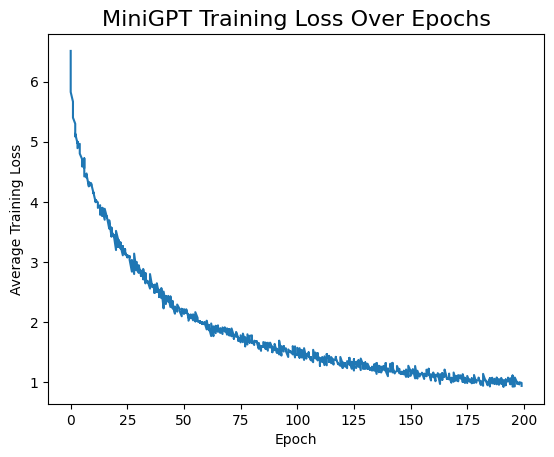

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# this is a saved csv based on the logger in trainini
metrics = pd.read_csv("metrics_final.csv")

epoch_losses = metrics
plt.plot(epoch_losses["epoch"], epoch_losses["train_loss"])
plt.xlabel("Epoch")
plt.ylabel("Average Training Loss")
plt.title("MiniGPT Training Loss Over Epochs", fontsize = 16)
plt.show()

# 2. Evaluate Perplexity

In [24]:
def compute_perplexity(model, dataloader):
    model.eval()
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        ct = 0
        for input_ids, label_ids in dataloader:
            ct +=1
            logits = model(input_ids)
            loss = model.loss(logits.view(-1, model.num_tokens), label_ids.view(-1))
            total_loss += loss.item() * input_ids.size(0)
            total_samples += input_ids.size(0)
            if ct % 20 == 0:
              break
    avg_loss = total_loss / total_samples
    perplexity = torch.exp(torch.tensor(avg_loss))
    return perplexity

In [28]:
# Perplexity over
def load_saved_model(i):
  checkpoint_path = os.path.join(f'day_6_model_{i}.pt') #save_loc_my_drive, #day_6_Gutenburg_test_4_model_
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint['model_state_dict'])
  return model

In [29]:
perplexity_track = []
for each in range(25,225,25):
  # model = load_saved_model(each)
  model = load_saved_model(each)
  model.eval()
  perplexity = compute_perplexity(model, dataloader)
  print(f"Model iterations {each} and Perplexity: {perplexity:.2f}")
  perplexity_track.append(perplexity)
# Set the model to evaluation mode (important for inference)
# model.eval()

Model iterations 25 and Perplexity: 15.20
Model iterations 50 and Perplexity: 4.96
Model iterations 75 and Perplexity: 2.88
Model iterations 100 and Perplexity: 2.15
Model iterations 125 and Perplexity: 1.79
Model iterations 150 and Perplexity: 1.56
Model iterations 175 and Perplexity: 1.43
Model iterations 200 and Perplexity: 1.34


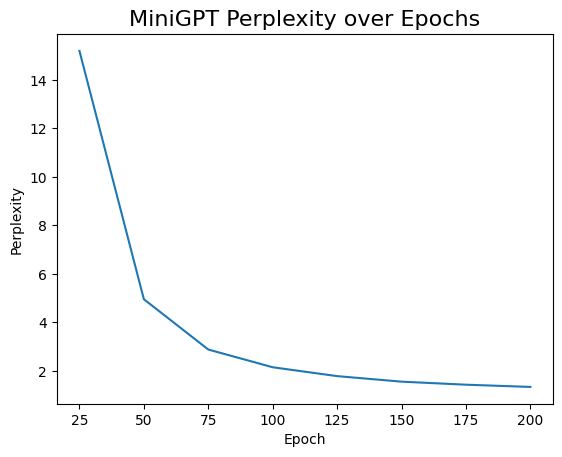

In [31]:
plt.plot(range(25,225,25), perplexity_track)
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("MiniGPT Perplexity over Epochs", fontsize = 16)
plt.show()

# 3. Human Evaluation - Model inference

In [32]:
def model_inference(model, prompt,token_to_id,response_type, temperature,sentences):
    tokens_big = tokenizer.tokenize(prompt)
    prompt_tokens = [token_to_id.get(token, token_to_id["<pad>"]) for token in tokens_big]
    # print the prompt
    print("\033[91mPrompt:\033[0m")
    print(prompt)

    # response_type : 1 = Fixed
    torch.manual_seed(42)  # Fix random seed
    model.eval()           # Disable dropout and batch norm
    model_input = torch.tensor(prompt_tokens) #, token_to_id["is"], token_to_id["where"]

    model_input = model_input.unsqueeze(0)  # Shape: [1, seq_len]
    input_length = model_input.size(dim=1)  # Now use dim=1 for seq_len
    predictions = model(model_input)
    def pred_by_distribution(pred,temp):
        g = torch.Generator().manual_seed(1)
        prob = torch.softmax(pred[0][-1,:]/temp, dim=-1)
        pred_id = torch.multinomial(prob, num_samples=1, generator = g)
        return pred_id
    if response_type == 1:
        predicted_id = torch.tensor([torch.argmax(predictions[0][-1,:])])
    else:
        predicted_id = pred_by_distribution(predictions,temperature)
    predicted_ids = predicted_id

    sent_ct = 0
    while True:
        if predicted_id == token_to_id["."]:
            sent_ct +=1
        if sent_ct == sentences:
            break
        model_input = torch.cat((model_input, predicted_id.unsqueeze(0)), dim=1)
        predictions = model(model_input)
        if response_type == 1:
            predicted_id = torch.tensor([torch.argmax(predictions[0][-1,:])])
        else:
            predicted_id = pred_by_distribution(predictions,temperature)
        predicted_ids = torch.cat((predicted_ids, predicted_id))

    # print("Model Response:")
    print("\033[94mModel Response:\033[0m")
    for each in predicted_ids:
        print(id_to_token[each.item()].replace('Ġ', ''), end=" ", flush=True)
        if id_to_token[each.item()] == ".":
            print()
        time.sleep(.2)

In [ ]:
# Load the saved models and run inference
checkpoint_path = os.path.join('day_6_model_200.pt') #save_loc_my_drive,
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
# Load the model state_dict
model.load_state_dict(checkpoint['model_state_dict'])
# Set the model to evaluation mode (important for inference)
model.eval()

## Human evaluation - prompt responses from the trained MiniGPT model

In [33]:
# Prompt - 1
prompt = "i love the sound of autotuned vocals."
model_inference(model, prompt,token_to_id,response_type = 1,temperature = 1,sentences = 3)

Prompt:
i love the sound of autotuned vocals.
Model Response:
i bought my own recording equipment for singing . 
i also bought some audio software so i could aut ot une myself . 
my tracks all turned out silly and erratic . 


In [34]:
# Prompt - 2
prompt = "i woke up am in the morning."
model_inference(model, prompt,token_to_id,response_type = 2,temperature = 0.1,sentences = 6)

Prompt:
i woke up am in the morning.
Model Response:
i prepared breakfast and got a glass of milk . 
there was no cereal . 
i looked inside and saw a strange object . 
i looked in the mirror . 
i decided to call it out , where i could go . 
now i miss anything in it and ruined . 


In [35]:
# Prompt - 3
prompt = "one sunny day the sky suddenly became dark and cloudy."
model_inference(model, prompt,token_to_id,response_type = 2,temperature = 0.5,sentences = 4)

Prompt:
one sunny day the sky suddenly became dark and cloudy.
Model Response:
this change in weather caught ke lly by surprise . 
she ran for cover under trees as she could . 
she chose the house next day . 
she ran straight to the ground and j ay went back to her room . 


In [36]:
# Prompt - 4
prompt = "my friend and i went"
model_inference(model, prompt,token_to_id,response_type = 2,temperature = 1,sentences = 4)

Prompt:
my friend and i went
Model Response:
to the beach . 
we watched the sunset . 
they saw a mountain lake and went home . 
we saw a nice seafood salad . 


# 4. Embedding Visualization

In [19]:
# Variable to store embeddings
final_embeddings = None

# Define a hook to capture the input to fc_layer
def hook_fn(module, input, output):
    global final_embeddings
    final_embeddings = input[0]  # input[0] is the tensor before fc_layer

# Register the hook on fc_layer
hook = model.fc_layer.register_forward_hook(hook_fn)

# Run forward pass
# prompt = "the animal did not cross the street because it was too tired"
prompt = "cat dog king man queen woman girl boy he she they pasta jar salad pizza" #perplexity=6 works best
# prompt = "cat dog king man queen woman he she they pasta jar salad pizza"

# prompt = "cat dog king man queen woman pasta salad pizza find search look"

tokens_big = tokenizer.tokenize(prompt)
prompt_tokens = [token_to_id.get(token, token_to_id["<pad>"]) for token in tokens_big]
tok_prompt = [id_to_token[each].replace('Ġ','') for each in prompt_tokens]


token_ids = torch.tensor([prompt_tokens])  # "the cat sat"
with torch.no_grad():
    _ = model(token_ids)  # Normal forward pass to trigger the hook

# Remove the hook (optional, if you only need it once)
hook.remove()

# Check the embeddings
print(final_embeddings.shape)  # torch.Size([1, 3, 2])
# print(final_embeddings)

torch.Size([1, 15, 256])


In [ ]:
# pos_dict.keys()
pos_dict['VB']

['get',
 'go',
 'be',
 'have',
 'make',
 'see',
 'find',
 'do',
 'buy',
 'take',
 'know',
 'let',
 'come',
 'give',
 'run',
 'leave',
 'keep',
 'believe',
 'save',
 'lose',
 'ken',
 'say',
 'slow',
 'remember',
 'realize',
 'kitten',
 'pen',
 'happen',
 'improve',
 'eaten',
 'replace',
 'apply',
 'add',
 'recognize',
 'remove',
 'follow',
 'expect',
 'develop',
 'allow',
 'apologize',
 'participate',
 'kindergarten',
 'reduce',
 'settle',
 'rotten',
 'epipen',
 'traumatize',
 'qualify',
 'appear',
 'ostracize',
 'succeed',
 'obtain',
 'assume',
 'kindle',
 'tranquilize',
 'rationalize',
 'rectify',
 'consider',
 'socialize',
 'aspen']

In [224]:
len(tok_prompt)

15

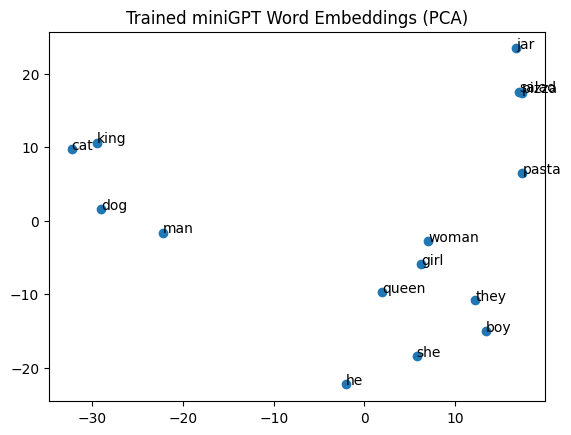

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Flatten embeddings for PCA (if multiple sequences, concatenate them)
embeddings_np = final_embeddings.squeeze(0).cpu().numpy()  # [3, 2]
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_np)

# Plot
tokens = tok_prompt
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
for i, token in enumerate(tokens):
    plt.annotate(token, (embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.title("Trained miniGPT Word Embeddings (PCA)")
plt.show()


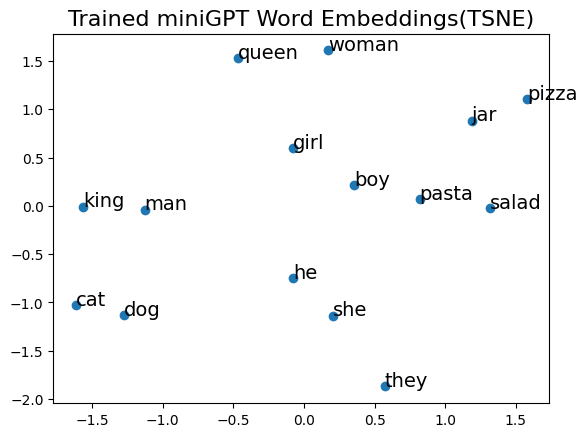

In [20]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
embeddings_np = final_embeddings.squeeze(0).cpu().numpy()  # [3, 2]
tsne = TSNE(n_components=2, random_state=42, perplexity=6, n_iter=1000)
tsne_2d = tsne.fit_transform(embeddings_np)
scaler = StandardScaler()

embeddings_2d = scaler.fit_transform(tsne_2d)
# Plot
tokens = tok_prompt
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
for i, token in enumerate(tokens):
    plt.annotate(token, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize = 14)
plt.title("Trained miniGPT Word Embeddings(TSNE)", fontsize = 16)
plt.show()

# 5. Attention Analysis

## Attention Heatmap of weights

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
# prompt = "the animal did not cross the street because it was too tired"
# prompt = "the cat was wet and it was cold"
prompt = "the cat was out and it was wet"
tokens_big = tokenizer.tokenize(prompt)
prompt_tokens = [token_to_id.get(token, token_to_id["<pad>"]) for token in tokens_big]
tok_prompt = [id_to_token[each].replace('Ġ','') for each in prompt_tokens]

In [45]:
# response_type : 1 = Fixed
torch.manual_seed(42)  # Fix random seed
model.eval()           # Disable dropout and batch norm
model_input = torch.tensor(prompt_tokens) #, token_to_id["is"], token_to_id["where"]

model_input = model_input.unsqueeze(0)  # Shape: [1, seq_len]
input_length = model_input.size(dim=1)  # Now use dim=1 for seq_len
# predictions = model(model_input)
with torch.no_grad():
    predictions = model(model_input)

In [46]:
# attn_weights = model.layers[1].self_attention.attention_percents[0, 0, :, :]  # [batch_size, num_heads, seq_len, seq_len]

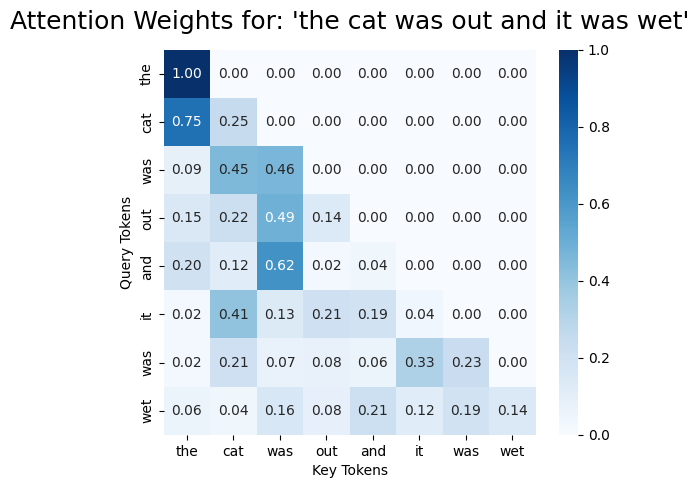

In [47]:
from matplotlib import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
rcParams['axes.titlepad'] = 15
attn_weights = model.layers[1].self_attention.attention_percents[0, 15, :, :]  # [batch_size, num_heads, seq_len, seq_len]
plt.figure(figsize=(6, 5))
sns.heatmap(
    attn_weights.numpy(),  # Move to CPU if on GPU
    annot=True,                  # Show values in cells
    fmt=".2f",                   # Format to 2 decimal places
    cmap="Blues",                # Color scheme
    xticklabels=tok_prompt,          # Key tokens (columns)
    yticklabels=tok_prompt           # Query tokens (rows)
)
plt.title(f"Attention Weights for: '{prompt}'",fontsize = 18)
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()

## Network Graphs of attention

In [191]:
# prompt = "the animal did not cross the street because it was too tired"
# prompt = "the cat was wet and it was cold"
prompt = "the cat was out and it was wet"
# prompt = "cat sat on the mat but it was wet"
# prompt = "cat said it was god"
tokens_big = tokenizer.tokenize(prompt)
prompt_tokens = [token_to_id.get(token, token_to_id["<pad>"]) for token in tokens_big]
tok_prompt = [id_to_token[each].replace('Ġ','') for each in prompt_tokens]

# response_type : 1 = Fixed
torch.manual_seed(42)  # Fix random seed
model.eval()           # Disable dropout and batch norm
model_input = torch.tensor(prompt_tokens) #, token_to_id["is"], token_to_id["where"]

model_input = model_input.unsqueeze(0)  # Shape: [1, seq_len]
input_length = model_input.size(dim=1)  # Now use dim=1 for seq_len
# predictions = model(model_input)
with torch.no_grad():
    predictions = model(model_input)

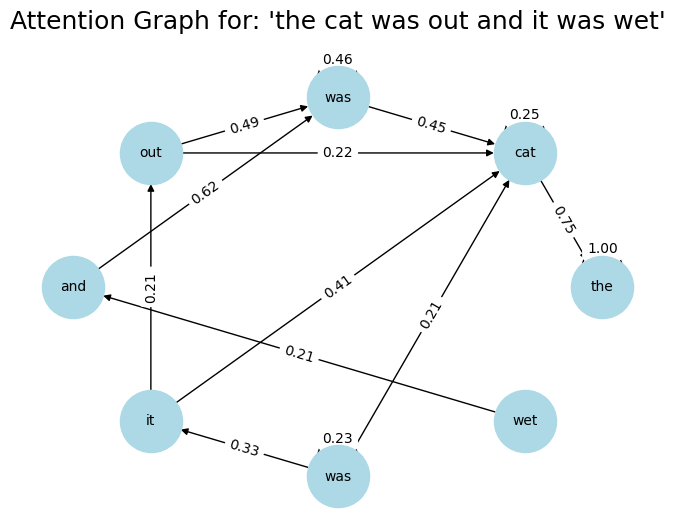

In [217]:
import networkx as nx
import matplotlib.pyplot as plt

tokens = tok_prompt

attn_weights = model.layers[1].self_attention.attention_percents[0, 15, :, :]

# Create a directed graph
G = nx.DiGraph()

# Add nodes
for i, token in enumerate(tokens):
    G.add_node(i, label=token)

# Add edges (threshold > 0.1)
for i in range(len(tokens)):
    for j in range(len(tokens)):
        # if i == j:
        #   G.add_edge(i, j, weight=0)
        # else:
        weight = attn_weights[i][j]
        if weight > 0.2:
        # if weight == max(attn_weights[i]):
            G.add_edge(i, j, weight=weight)

# Plot
pos = nx.circular_layout(G)
labels = nx.get_node_attributes(G, 'label')
edge_labels = {(i, j): f"{d['weight']:.2f}" for i, j, d in G.edges(data=True)}

nx.draw(G, pos, with_labels=True, labels=labels, node_color='lightblue', node_size=2000, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title(f"Attention Graph for: '{prompt}'",fontsize = 18)
plt.show()